# Network science
  # PAOLA LOI 


This project aims to analyze a complex system modeled as a network by computing key structural metrics and applying community detection algorithms. Additionally, machine learning tasks on graphs are developed, including node classification, link prediction, and graph classification.


### PACKAGES 

In [67]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Image
import statsmodels.api as sm
import scipy.stats as sp
import seaborn as sns 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


from node2vec import Node2Vec
from seaborn.external.docscrape import header
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import silhouette_score
from networkx.algorithms.community import modularity
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score



In [60]:
print("Numpy version:", np.__version__)

Numpy version: 1.26.4


### DATA LOADING


In [1]:
nodes = pd.read_csv('//Users//paolaloi//Desktop//Network Science//fb-pages-politician//fb-pages-politician.nodes') 
edges = pd.read_csv('//Users//paolaloi//Desktop//Network Science//fb-pages-politician//fb-pages-politician.edges',names=['source', 'target'])

nodes.head()


NameError: name 'pd' is not defined

### GRAPH MODELLING

In [8]:
G = nx.Graph()
for idx, row in nodes.iterrows():
    G.add_node(row['new_id'], name=row['name']) 

for idx, row in edges.iterrows():
    G.add_edge(row['source'], row['target'])
    
print(G)


Graph with 5908 nodes and 41729 edges


### Metadata 
The dataset used represents a network of verified Facebook pages (nodes) linked by “mutual like” relationships (edges), collected in November 2017. This is an undirected and unweighted graph: the direction is not relevant since the link is symmetric, and no
quantitative information is available to assign weights to the edges. This modeling choice reflects the nature of the data
collected, where the goal is to represent the simple existence of relationships between pages, without further attributes on their “degree of like”. The resulting
graph has 5908 nodes and 41729 edges. 

### Gephi visualization 

In [9]:
nx.write_gexf(G,'//Users//paolaloi//Desktop//Network Science//ProjectGraph.gexf')

In [10]:
nx.write_gexf(G,'//Users//paolaloi//Desktop//Network Science//Project.NSGraph.gexf')

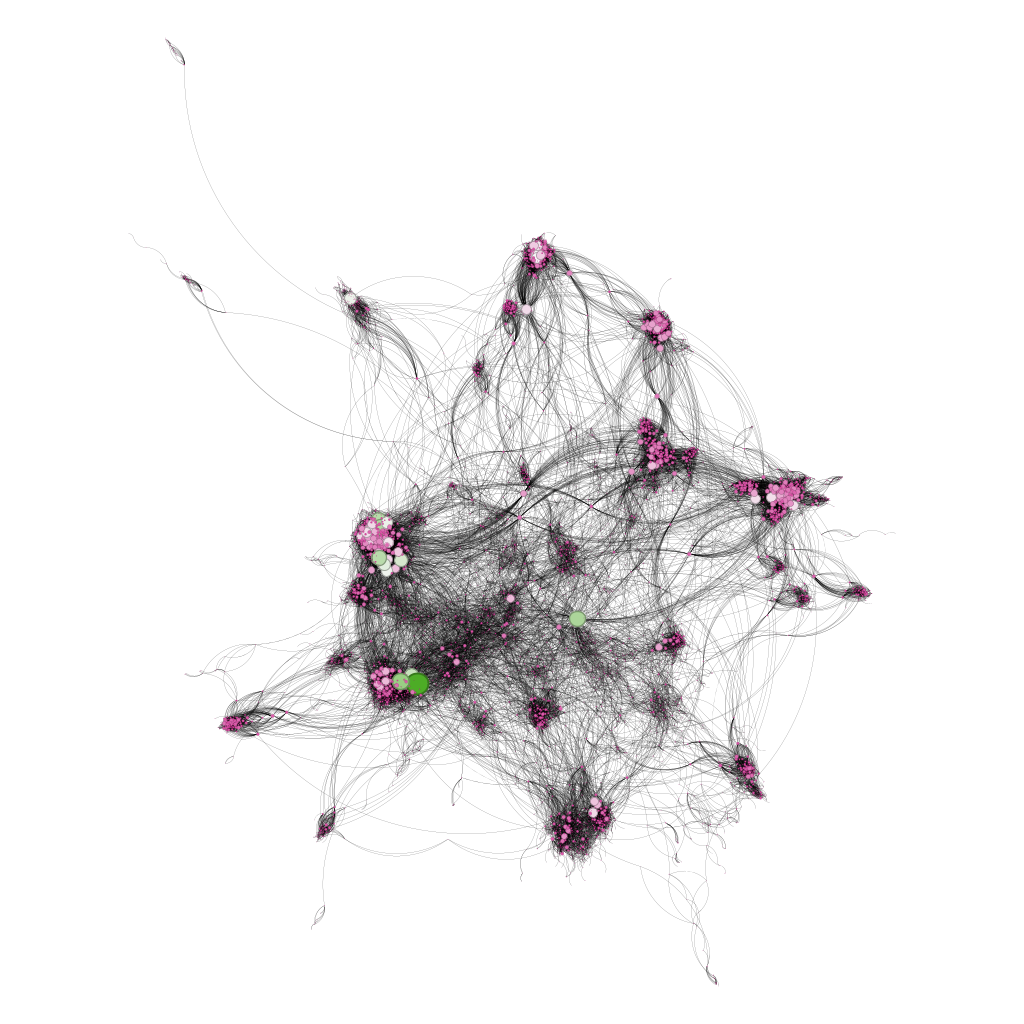

In [11]:
img_path = '/Users/paolaloi/Desktop/Network Science/NSimm.png'
display(Image(filename=img_path))

In [12]:
components = list(nx.connected_components(G))
LCC = max(components, key=len) 
giant_G = G.subgraph(LCC).copy()

print(f"Number of connected components: {len(components)}")

Number of connected components: 1


The network has a single connected component. Visually, several well-defined clusters emerge, in which pink and small nodes aggregate around a few larger nodes, tending towards green, which act as hubs thanks to their high degree of connection. The presence of these hubs promotes global interconnection and prevents the formation of independent components.

# NETWORK ANALYSIS

### DEGREE AND DENSITY 


In [13]:
degrees = dict(G.degree())
avg_degree = sum(degrees.values()) / len(degrees)
print("Average degree:", avg_degree)

N = G.number_of_nodes()
L = G.number_of_edges()
density = (2 * L) / (N * (N - 1))
print("Density of the network:", density)

L_max = N*(N-1)/2
print("Number of edges (L):", L)
print("Maximum number of edges (L_max):", L_max)
print("Density (Δ):", density)
if density < 0.01:
    print("The network is sparse")
else:
    print("The network is not sparse")


Average degree: 14.126269465132024
Density of the network: 0.002391445651791438
Number of edges (L): 41729
Maximum number of edges (L_max): 17449278.0
Density (Δ): 0.002391445651791438
The network is sparse


The average degree is about 14, which means that, on average, each node is connected to a small fraction of the total number of other nodes in the network. This is
further confirmed by the value of the density, equal to about 0.0024: the density is defined as the ratio between the actual number of arcs L and the maximum number
 of possible arcs. Such a low density indicates that only a minimal part of the potential connections is actually present.

This situation is typical of large real networks, which almost always turn out to be sparse. This means that, despite having a high number of nodes, they are not
densely connected. The consequence is that such networks have a structural organization with few "hubs" and many low-degree nodes, without arriving at a situation
in which the majority of nodes are densely interconnected. Ultimately, the data confirm the theoretical expectations: the network under analysis is a sparse
network, with a number of arcs L=41729 compared to a maximum number of potential arcs L_max=17449278.

### Scale-free network? 

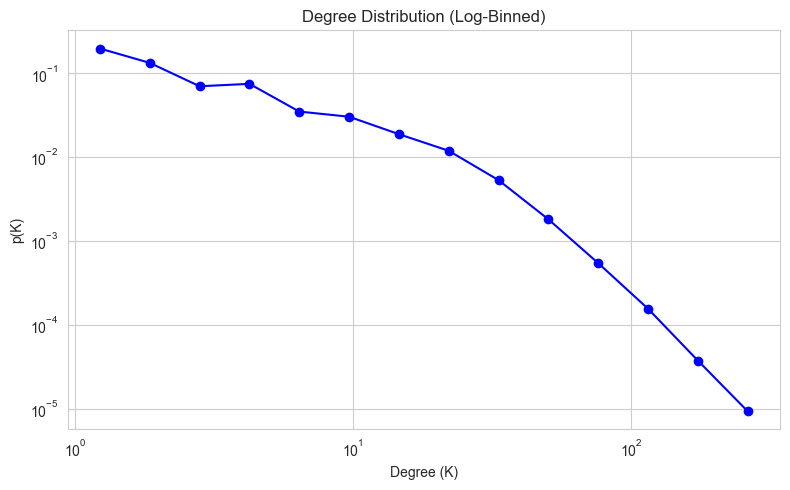

In [14]:
degrees = [d for _, d in G.degree()]
degrees = np.array(degrees)

#bins creation 
min_degree = np.min(degrees[degrees>0])
max_degree = np.max(degrees)
num_bins = 15  

bins = np.logspace(np.log10(min_degree), np.log10(max_degree), num_bins)
hist, edges = np.histogram(degrees, bins=bins)

# pk evaluation
bin_widths = np.diff(edges)
pk = hist / (len(degrees) * bin_widths)
bin_centers = (edges[:-1] * edges[1:])**0.5 

plt.figure(figsize=(8,5))
plt.loglog(bin_centers, pk, marker='o', linestyle='-', color='b', ms=6)
plt.xlabel("Degree (K)")
plt.ylabel("p(K)")
plt.title("Degree Distribution (Log-Binned)")
plt.tight_layout()
plt.show()

The log-log scale degree distribution plot shows a linear trend, particularly evident for high degrees. This pattern is indicative of a scale-free network, where the degree distribution follows a **power law**.

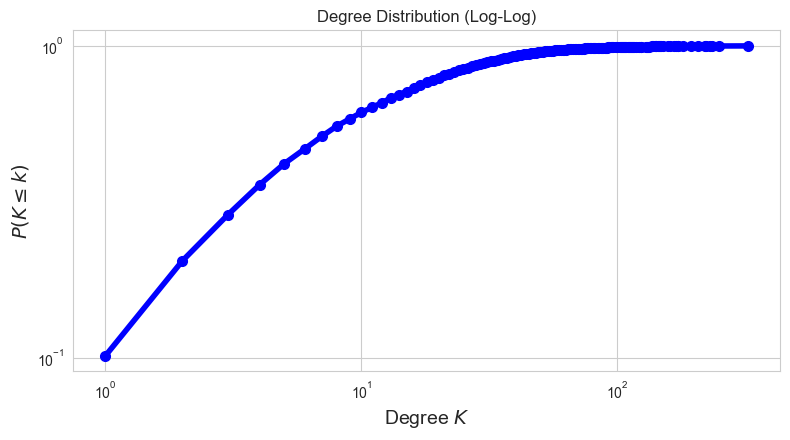

In [15]:
degree_sample = list(dict(G.degree()).values())
ecdf = sm.distributions.ECDF(degree_sample)
x = np.unique(degree_sample)
y = ecdf(x)

fig = plt.figure(figsize=(8, 4.5))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(x, y, lw=4, ls='-', ms=7, marker='o', color='blue')
ax.set_xlabel(r'Degree $K$', fontsize=14)
ax.set_ylabel(r'$P(K \leq k)$', fontsize=14) 
plt.title("Degree Distribution (Log-Log)")
plt.tight_layout()
plt.show()

Looking at the log-log plot, the presence of a long and heavy tail in the graph further confirms that few nodes in the network have a higher than average number of connections, a distinctive feature of scale-free networks. These highly connected nodes play a crucial role in the structure and functioning of the network in terms of robustness and connectivity.

We than proceed with the identification and study of these nodes

### HUB DETECTION

In [16]:
degree_dict = dict(G.degree())
hub_threshold = np.percentile(list(degree_dict.values()), 95)

print(hub_threshold)

hubs = {node for node, degree in degree_dict.items() if degree >= hub_threshold}
print("Hubs:", hubs)

hub_graph = G.subgraph(hubs).copy()
connected_components = list(nx.connected_components(hub_graph))
connected_componentss = list(nx.connected_components(G))
print('Connected components:', len(connected_componentss))
number_of_components = len(connected_components)

id_to_name = pd.Series(nodes['name'].values, index=nodes['new_id']).to_dict()
named_components = []
for component in connected_components:
    named_components.append({id_to_name[node] for node in component if node in id_to_name})
for i, component in enumerate(named_components, 1):
    print(f"Component {i}: {component}")

48.0
Hubs: {1025, 516, 5638, 519, 3079, 2059, 2060, 2572, 3595, 5644, 5643, 5137, 18, 1043, 4113, 4622, 3094, 3087, 4120, 5657, 3099, 541, 3617, 4643, 2083, 1061, 2086, 5808, 2088, 3110, 4135, 1067, 1581, 46, 5166, 3121, 2612, 55, 1595, 4667, 61, 4158, 2111, 4160, 2624, 1602, 1091, 1092, 5701, 3140, 4674, 5705, 589, 2639, 3665, 4180, 598, 2647, 4185, 3162, 1625, 92, 93, 5726, 3680, 1632, 5729, 98, 3684, 3170, 1127, 617, 2153, 1641, 108, 4205, 3696, 112, 2160, 1651, 2676, 630, 121, 4219, 2173, 4735, 641, 2690, 133, 1159, 2698, 1675, 3211, 4749, 1680, 147, 3219, 4759, 4761, 2713, 1178, 155, 5785, 4253, 2723, 2725, 165, 5797, 3752, 169, 3242, 2218, 683, 5800, 1707, 1711, 175, 1201, 178, 2738, 4274, 4789, 179, 2230, 2736, 5305, 698, 4284, 190, 191, 192, 3263, 2242, 195, 1215, 3270, 2759, 2760, 5833, 3281, 210, 2770, 724, 3793, 726, 3801, 4829, 1758, 3807, 735, 5855, 5346, 739, 4835, 4838, 1766, 3306, 5867, 5355, 5357, 750, 5871, 1263, 5879, 2296, 3833, 2298, 5882, 4857, 5885, 766, 2815, 76

The analysis identifies hubs within the network, defined as nodes with at least **48 connections**, based on the 95th percentile threshold. These hubs represent the most connected and influential nodes in the graph. A subgraph composed of these hubs was extracted to examine their connectivity, revealing 4 connected components.

The overall graph remains **connected**, as indicated by the output showing a single connected component for the full graph. However, within the hub subgraph, the components are fragmented:
	
    •	Component 1 is the largest, comprising highly interconnected nodes that form a central core of influential individuals within the network.

	•	Component 2 includes a smaller group of less-connected hubs, demonstrating localized influence.

	•	Components 3 and 4 consist of isolated hubs that, while highly connected in the full graph, lack significant connections with other hubs in the subgraph.

This analysis highlights the hierarchical structure of the network, where central hubs maintain strong interconnections, while others remain locally influential.

In [18]:
hubs_ccs = len(list(nx.connected_components(G.subgraph(hubs).copy())))
hubs_ccs

4

Given the characteristics observed in the network, it is not unusual to have 4 components and can be interpreted through the Barabási-Albert model. This model suggests that the network evolves over time through a preferential attachment mechanism, according to which new nodes tend to preferentially attach to nodes that are already well connected, thus promoting the formation of hubs as the network grows.

The presence of separate components can be explained if nodes introduced at later stages have not had the opportunity or sufficient probability to attach to the existing more connected nodes. This phenomenon also helps to explain the variation in the size of the various components of the network, reflecting a dynamic evolution in which the integration of new nodes does not always consolidate or expand the main component, but can instead result in the formation of new clusters.

### TRANSITIVITY 

In [19]:
#using measure based on triangles
def calculate_global_clustering(G):  
    triangles = sum(nx.triangles(G).values()) // 3  
    open_triplets = 0

    for v in G:
        neighbors = list(nx.neighbors(G, v))
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                if not G.has_edge(neighbors[i], neighbors[j]):
                    open_triplets += 1

    
    closed_triplets = 3 * triangles  
    total_triplets = closed_triplets + open_triplets

    if total_triplets == 0:
        return 0
    return closed_triplets / total_triplets

global_clustering_coefficient = calculate_global_clustering(G)
print("Global Clustering Coefficient:", global_clustering_coefficient)



Global Clustering Coefficient: 0.3010737363311825


In [20]:
#just to check first computation 
transitivity_nx = nx.transitivity(G)
print("Transitivity:", transitivity_nx)

#local clustering coefficient 
local_clustering = list(nx.clustering(G).values())
print("Average Local Clustering Coefficient:", sum(local_clustering) / len(local_clustering))


Transitivity: 0.3010737363311825
Average Local Clustering Coefficient: 0.38509612579327435


The **Global Clustering Coefficient** is equal to 0.301, indicating that about **30.1%** of the possible triplets form closed triangles. This value highlights a moderate tendency to form clusters on a global scale, suggesting the existence of well-defined but not extremely dense communities. In parallel, the **Average Local Clustering Coefficient** is 0.385, showing that, on average, nodes realize **38.5%** of their possible connections between neighbors. This highlights the presence of small communities or locally cohesive groups.

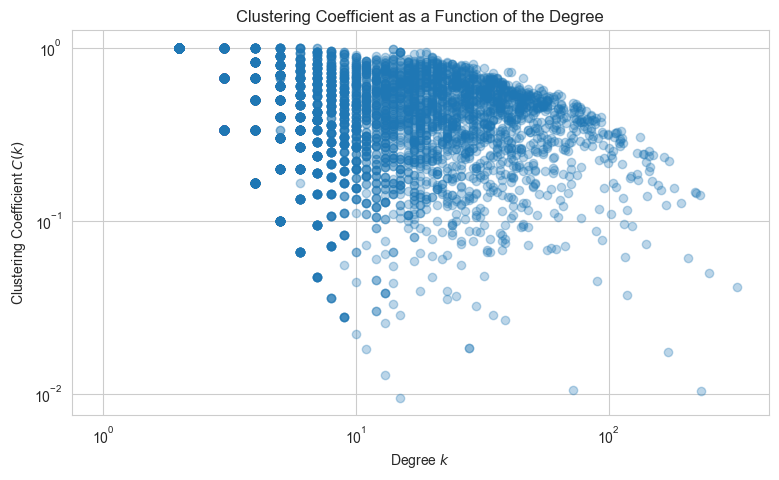

In [21]:
local_clustering_dict = nx.clustering(G)
degree_dict = dict(G.degree())
x, y = zip(*((degree_dict[node], clust_coeff) for node, clust_coeff in local_clustering_dict.items()))

fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x, y, alpha=0.3)  
ax.set_xscale('log')  
ax.set_yscale('log') 
ax.set_xlabel('Degree $k$')  
ax.set_ylabel('Clustering Coefficient $C(k)$') 
ax.set_title('Clustering Coefficient as a Function of the Degree') 

plt.show()

The plot represents the clustering coefficient as a function of node degree on a logarithmic scale. It can be seen that nodes with a low number of links show a high clustering coefficient, indicating that they tend to form closed triads, i.e. small, tight communities. On the contrary, nodes with many links have lower clustering coefficients, suggesting that, although they connect different parts of the network, their neighbors are not tightly interconnected. This pattern confirms the scale-free structure of the network, where a few central nodes facilitate connectivity between many distant, less connected nodes, without necessarily creating dense clusters.

### CENTRALITY

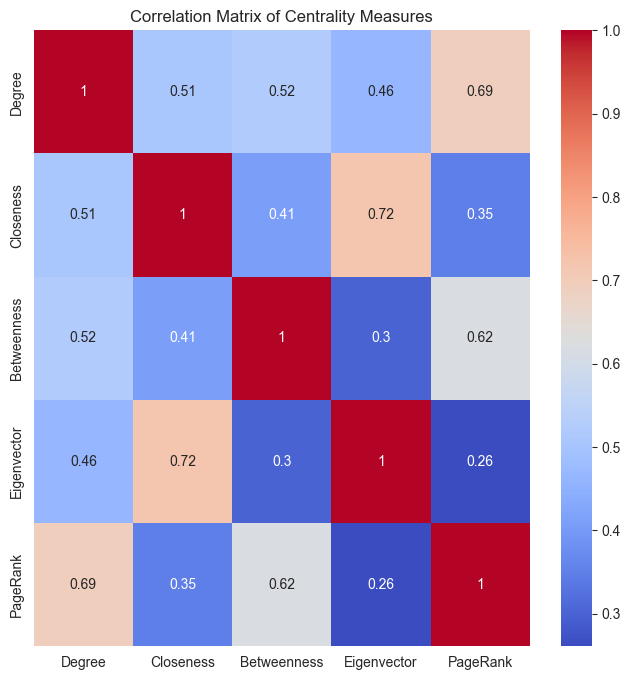

In [22]:
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
pagerank = nx.pagerank(G)

df_centrality = pd.DataFrame({
    'Degree': pd.Series(degree_centrality),
    'Closeness': pd.Series(closeness_centrality),
    'Betweenness': pd.Series(betweenness_centrality),
    'Eigenvector': pd.Series(eigenvector_centrality),
    'PageRank': pd.Series(pagerank)
})

corr = df_centrality.corr(method='kendall')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation Matrix of Centrality Measures')
plt.show()

The **analysis of centrality measures** in the network highlights the crucial role of hubs and their ability to influence the distribution of information. The high correlation between degree and PageRank confirms the importance of these central nodes, which not only have numerous direct connections, but also significantly determine the flow of resources in the network. Furthermore, the correlation between closeness and eigenvector centrality demonstrates that central nodes are often interconnected, forming a group of influential nodes that facilitates the effective transfer of information. The correlation of 0.52 between degree and betweenness centrality indicates that nodes with many connections also tend to be important intermediaries in the network, influencing the flow of information significantly. These nodes, being often situated on critical paths, are vital for the cohesion and robustness of the network, but their removal could lead to significant disruptions.


In [23]:
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

top_n = 10
top_betweenness = top_betweenness[:top_n]

print("Top {} nodes by betweenness centrality:".format(top_n))
for node_id, bc_value in top_betweenness:
    node_name = G.nodes[node_id]['name']
    print(f"Node ID: {node_id}, Name: {node_name}, Betweenness: {bc_value}")

Top 10 nodes by betweenness centrality:
Node ID: 5800, Name: Barack Obama, Betweenness: 0.2683376978223287
Node ID: 1864, Name: Manfred Weber, Betweenness: 0.055516710547232735
Node ID: 3576, Name: Angela Merkel, Betweenness: 0.054119477614629485
Node ID: 2900, Name: Hillary Clinton, Betweenness: 0.04830356638479759
Node ID: 1324, Name: Justin Trudeau, Betweenness: 0.04510631854551859
Node ID: 3008, Name: Sir Peter Bottomley MP, Betweenness: 0.03726160625260532
Node ID: 1965, Name: Malcolm Turnbull, Betweenness: 0.035353462127597476
Node ID: 4395, Name: Narendra Modi, Betweenness: 0.03407402412149911
Node ID: 191, Name: Loïc Hervé, Betweenness: 0.03178356809415838
Node ID: 1836, Name: Boris Johnson, Betweenness: 0.028978190316895757


Analyzing **betweenness centrality** in your network reveals the critical role of key nodes such as Barack Obama, who with the highest value, acts as the main intermediary in the flow of information, highlighting his centrality in connecting different parts of the network. Other political leaders such as Manfred Weber, Angela Merkel and Hillary Clinton, although with slightly lower values, play similar roles, acting as central nodes in communication paths. The presence of these nodes with high betweenness indicates that the network is strongly influenced by figures of power, who control information and can act as strategic control points within the network. Identifying and understanding the role of these intermediaries is essential to optimize the efficiency of the network and to develop strategies that increase its resilience, reducing dependence on these central nodes and improving the overall stability of the network.

In [25]:
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

top_n = 10
top_degree = top_degree[:top_n]

print("Top {} nodes by degree centrality:".format(top_n))
for node_id, dc_value in top_degree:
    node_name = G.nodes[node_id]['name']
    print(f"Node ID: {node_id}, Name: {node_name}, Degree Centrality: {dc_value}")

Top 10 nodes by degree centrality:
Node ID: 1864, Name: Manfred Weber, Degree Centrality: 0.05468088708312172
Node ID: 4874, Name: Joachim Herrmann, Degree Centrality: 0.04232266802099204
Node ID: 5800, Name: Barack Obama, Degree Centrality: 0.03944472659556458
Node ID: 5416, Name: Katarina Barley, Degree Centrality: 0.038767563907228714
Node ID: 1595, Name: Arno Klare MdB, Degree Centrality: 0.037582529202640935
Node ID: 4602, Name: Katja Mast, Degree Centrality: 0.037243947858473
Node ID: 3576, Name: Angela Merkel, Degree Centrality: 0.03504316912138141
Node ID: 1474, Name: Martin Schulz, Degree Centrality: 0.03267309971220586
Node ID: 4032, Name: Niels Annen, Degree Centrality: 0.03064161164719824
Node ID: 4972, Name: Heike Baehrens, Degree Centrality: 0.029287286270526496


These super-connectors, essential for the cohesion and functionality of the network, play a crucial role in facilitating communication and could be strategic targets for optimizing or protecting the network. Their influential positions mean that any disruption in their activity could significantly impact the entire network structure.

Centrality analysis shows that key figures such as Barack Obama, Manfred Weber, and Angela Merkel are vital nodes in the network, having both many direct connections and a crucial role in communication paths. While Obama and Weber dominate in both measures, Merkel, despite fewer direct connections, emerges as an important intermediary. In contrast, nodes such as Hillary Clinton and Justin Trudeau, while not among the most connected, are strategic in communication paths, indicating that their importance in the network transcends the simple number of connections. This highlights how different centrality measures can reveal different aspects of influence and control within the network.

### COMMUNITY DETECTION

In [26]:
nodes_list = list(G.nodes())
com4nodes = {n: {'lou': 0, 'clus': 0} for n in nodes_list}

list_community_sets = nx.community.louvain_communities(G)
for i, nodes in enumerate(list_community_sets):
    for node in nodes:
        com4nodes[node]['lou'] = i

In [27]:
node2vec = Node2Vec(G, dimensions=20, walk_length=12, num_walks=100, p=1, q=3, workers=4)
model = node2vec.fit(window=7, min_count=0, batch_words=4)

data_points = [model.wv[str(node)] for node in nodes_list]

Computing transition probabilities:   0%|          | 0/5908 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


The Louvain algorithm here used to detect communities in the network. This algorithm tries to maximize modularity, a value that measures how connected the nodes
within a community are compared to the entire network. Each node is assigned to a community by the index i, Node2Vec is applied to compute vector embeddings of
the nodes,capturing their structural and relational characteristics

In [29]:
kmeans = KMeans(n_clusters=len(list_community_sets), random_state=42, n_init='auto')
kmeans.fit(data_points)

for i, node in enumerate(nodes_list):
    com4nodes[node]['clus'] = kmeans.labels_[i]

In [30]:
v_louvain = np.zeros(len(nodes_list))
v_clus = np.zeros(len(nodes_list))
for i, node in enumerate(nodes_list):
    v_louvain[i] = com4nodes[node]['lou']
    v_clus[i] = com4nodes[node]['clus']

nmi_score = normalized_mutual_info_score(v_louvain, v_clus)
print("Normalized Mutual Information Score:", nmi_score)

Normalized Mutual Information Score: 0.8237667790058811


In [31]:
num_clusters = len(set(v_louvain))  
print("Number of clusters found:", num_clusters)

Number of clusters found: 30


The **Normalized Mutual Information (NMI)** Score result is **0.802**, a high value that indicates a strong similarity between the partitions obtained through the Louvain algorithm and the k-means clustering based on Node2Vec embeddings. This underlines the robustness of the applied community detection methods and their ability to detect coherent structures in the network.

The relatively high number of **clusters** identified in the network, equal to **30**, highlights a highly fragmented structure but with well-defined communities. In light
of the calculated values, we can conclude that the network is characterized by internal subgroups with good cohesion, which however are less connected to each other
 at a global level. This suggests that the network favors local interactions within communities rather than widespread connections between different clusters, a
 typical feature of complex networks such as social ones, where there are multiple aggregation centers with distinct and specific roles.

### Cluster evaluation 

In [32]:
louvain_communities = []
for cluster_id in set(v_louvain):
    cluster_nodes = [node for node, cluster in zip(nodes_list, v_louvain) if cluster == cluster_id]
    louvain_communities.append(set(cluster_nodes))

modularity_score = modularity(G, louvain_communities)
modularity_score

0.8682047437426144

A **modularity value of 0.8685** indicates a good subdivision of the network into communities, where the density of links within communities is significantly higher than the links between different communities. This result supports the effectiveness of the community detection algorithm used, confirming that the network is organized into distinct and coherent clusters, highlighting a clear segmentation of the relationships within the graph.

I now assign the belonging cluster to each node and visualize the partition with Gephi in a color-coded manner 

In [33]:
for node, cluster in zip(G.nodes(), v_louvain):
    G.nodes[node]['Cluster'] = int(cluster)  

path_to_save = "/Users/paolaloi/Desktop/Network_Science.graphml"
nx.write_graphml(G, path_to_save)

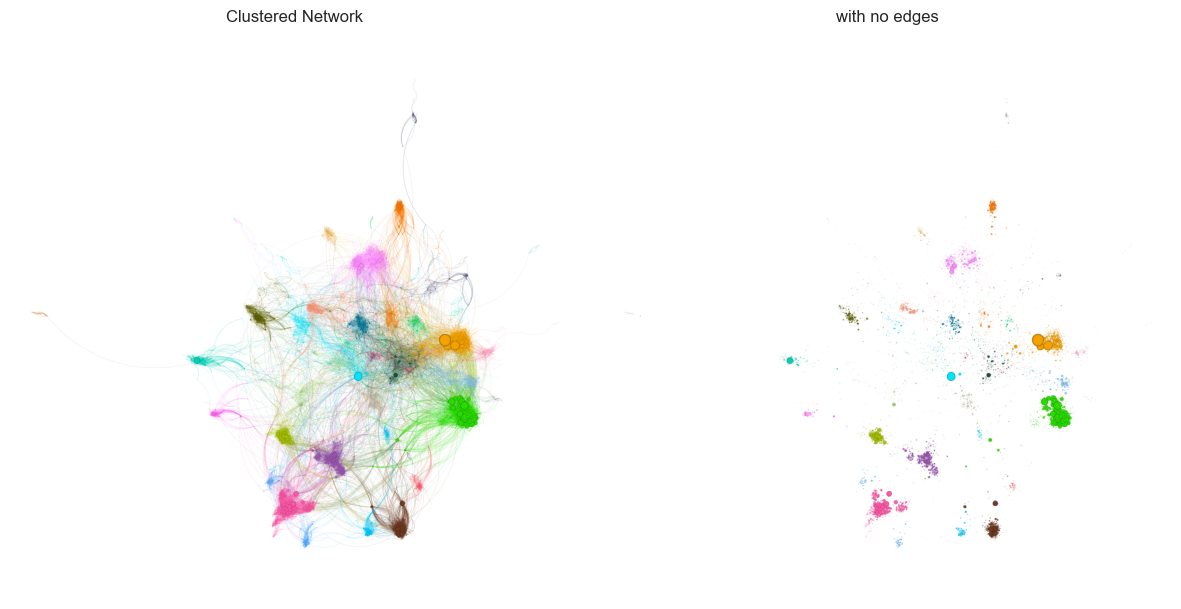

In [34]:
image_path1 = '/Users/paolaloi/Desktop/Network Science/NSclustered.png'
image_path2 = '/Users/paolaloi/Desktop/Network Science/NSclustered_noE.png'

img1 = mpimg.imread(image_path1)
img2_no_edges = mpimg.imread(image_path2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')  
axes[0].set_title("Clustered Network")

axes[1].imshow(img2_no_edges)
axes[1].axis('off')  
axes[1].set_title("with no edges")

plt.tight_layout()
plt.show()

Visual analysis of the clustered network shows clear modularity, with distinct clusters highlighting the presence of well-defined communities within the network. The larger central clusters likely act as major hubs, facilitating communication and connectivity between different areas of the network, while smaller clusters may indicate areas of more specialized or less intense interaction. This clustering, together with their clear visual separation, suggests that the network is organized so that there are zones of high internal connectivity, which is crucial for optimizing communication and network functions. This type of organization supports efficient information distribution and may have significant implications for intervention or network strengthening strategies.

In [35]:
def calculate_cluster_distribution(G, clusters):
    cluster_counts = pd.Series(clusters).value_counts().sort_index()
    total_nodes = len(G.nodes())
    cluster_percentages = (cluster_counts / total_nodes) * 100
    
    
    cluster_distribution = pd.DataFrame({
        'Cluster': cluster_counts.index,
        'Node Count': cluster_counts.values,
        'Percentage (%)': cluster_percentages.values
    }).round(2)  
    
    return cluster_distribution

cluster_distribution = calculate_cluster_distribution(G, v_louvain)

cluster_distribution

,Cluster,Node Count,Percentage (%)
0,0.0,161,2.73
1,1.0,103,1.74
2,2.0,217,3.67
3,3.0,99,1.68
4,4.0,8,0.14
5,5.0,17,0.29
6,6.0,233,3.94
7,7.0,53,0.90
8,8.0,617,10.44
9,9.0,123,2.08


The distribution of nodes in clusters highlights a highly heterogeneous Facebook network. The largest clusters (1, 3, 24) represent approximately 9% each of the
nodes, indicating large and thematically generic communities, while smaller clusters (<1%) suggest specific or sectoral interest groups. This structure reflects th
 modularity of the network, where large communities coexist with smaller groups, representing the variety of connections and interests of Facebook pages. The
 presence of such varied clusters underlines both the broad scope and the diversification of topics covered by the pages.

In [36]:
def calculate_cluster_metrics(G, clusters):
    cluster_data = []

    for cluster_id in set(clusters):
        nodes_in_cluster = [node for node, clust in zip(G.nodes(), clusters) if clust == cluster_id]
        subgraph = G.subgraph(nodes_in_cluster)

        avg_degree = round(sum(dict(subgraph.degree()).values()) / len(nodes_in_cluster), 2) if len(nodes_in_cluster) > 0 else 0
        density = round(nx.density(subgraph), 2) if len(nodes_in_cluster) > 1 else 0
        closeness_values = nx.closeness_centrality(subgraph) if len(nodes_in_cluster) > 1 else {}
        betweenness_values = nx.betweenness_centrality(subgraph) if len(nodes_in_cluster) > 1 else {}

        avg_closeness = round(np.mean(list(closeness_values.values())), 2) if closeness_values else 0
        avg_betweenness = round(np.mean(list(betweenness_values.values())), 2) if betweenness_values else 0

        cluster_data.append({
            'Cluster': cluster_id,
            'Average Degree': avg_degree,
            'Density': density,
            'Average Closeness': avg_closeness,
            'Average Betweenness': avg_betweenness
        })

    return pd.DataFrame(cluster_data)

cluster_metrics = calculate_cluster_metrics(G, v_louvain)
cluster_metrics

,Cluster,Average Degree,Density,Average Closeness,Average Betweenness
0,0.0,12.46,0.08,0.39,0.01
1,1.0,16.87,0.17,0.37,0.02
2,2.0,5.98,0.03,0.43,0.01
3,3.0,13.54,0.14,0.35,0.02
4,4.0,2.25,0.32,0.54,0.15
5,5.0,5.29,0.33,0.52,0.07
6,6.0,24.64,0.11,0.44,0.01
7,7.0,10.83,0.21,0.49,0.02
8,8.0,12.87,0.02,0.36,0.00
9,9.0,7.54,0.06,0.32,0.02


The cluster analysis highlights a highly heterogeneous network, with marked differences in the structural characteristics of the groups. Clusters with a high
average degree and moderate density (such as clusters 7 and 8) represent local hubs with many connections, but not excessively cohesive. Clusters with higher
densities, such as 4, show well-defined and compact communities, with nodes close to each other and quick access to internal information. On the contrary,
peripheral clusters such as 23 and 24 have low degree and density, reflecting less integrated and more isolated subgroups, but with potential strategic roles for
the connection of small subnetworks. The variability of betweenness and closeness values highlights central nodes with importance in the information flow and other
more marginal ones. This structure reflects the nature of the network analyzed, formed by Facebook pages of politicians connected by mutual “likes”, which symbolize
a flow of information and relationships between different areas of political communication.

# MACHINE LEARNING ON NETWORK 

In [37]:
positive_edges = list(G.edges())
non_edges = list(nx.non_edges(G))
negative_edges = np.random.choice(len(non_edges), len(positive_edges), replace=False)
negative_edges = [non_edges[i] for i in negative_edges]

edges_train_pos, edges_test_pos = train_test_split(positive_edges, test_size=0.2, random_state=42)
edges_train_neg, edges_test_neg = train_test_split(negative_edges, test_size=0.2, random_state=42)

train_df = pd.DataFrame(edges_train_pos + edges_train_neg, columns=['source', 'target'])
train_df['label'] = [1] * len(edges_train_pos) + [0] * len(edges_train_neg)
test_df = pd.DataFrame(edges_test_pos + edges_test_neg, columns=['source', 'target'])
test_df['label'] = [1] * len(edges_test_pos) + [0] * len(edges_test_neg)

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")


Training set size: 66766
Testing set size: 16692


Here I prepared the data for link prediction within a network by selecting and splitting existing (positive) and non-existing (negative) edges into training and testing sets into a DataFrame. 

### NETWORK SIMILARITY

Prepared new metrics and add them to the DataFrame, used later to compute link predictions. The **Jaccard coefficient** measures the similarity between the sets of neighbors of two nodes, enhancing the model’s ability to assess the likelihood of a link based on shared connections. The **Adamic-Adar index** enhances this evaluation by placing greater emphasis on rarer connections, acknowledging that shared interactions with less-connected nodes often indicate stronger relationships.

In [38]:
def jaccard_adamic(df, graph):
    jaccard = []
    adamic_adar = []
    for u, v in zip(df['source'], df['target']):
        u_neighbors = set(graph.neighbors(u))
        v_neighbors = set(graph.neighbors(v))
        intersection = u_neighbors & v_neighbors
        union = u_neighbors | v_neighbors
        jaccard.append(len(intersection) / len(union) if union else 0)
        adamic_adar.append(sum(1 / np.log(len(list(graph.neighbors(w)))) for w in intersection if graph.degree(w) > 1))
    df['jaccard'] = jaccard
    df['adamic_adar'] = adamic_adar
    return df

train_df = jaccard_adamic(train_df, G)
test_df = jaccard_adamic(test_df, G)


In [39]:
train_df.head()

,source,target,label,jaccard,adamic_adar
0,4901,3782,1,0.080645,1.041809
1,4482,4223,1,0.121951,1.807654
2,5052,1864,1,0.076220,7.470311
3,147,109,1,0.106918,4.607173
4,4857,1127,1,0.225564,6.898460


In [40]:
test_df.head()

,source,target,label,jaccard,adamic_adar
0,3074,3602,1,0.071429,0.954387
1,2928,3325,1,0.166667,1.558649
2,5212,4525,1,0.346154,6.018592
3,1355,3389,1,0.071429,0.294014
4,334,4558,1,0.021277,0.274908


Checking for DataFrame completeness we look at the coefficient calculated. For example the first node pair (trains set) has Jaccard coefficient=0.080. This value indicates that about 8.06% of the total unique neighbors between these two nodes are shared. This relatively low value might suggest that while there is some connection between the nodes, it’s not particularly strong based on common neighbors alone.
Instead, the Adamic-Adar index for this pair is 1.04. A higher value here compared to the Jaccard coefficient suggests that the few neighbors they do share are relatively significant.

### LINK PREDICTION (Random Forest)

In [68]:
X_train = train_df[['jaccard', 'adamic_adar']]  
y_train = train_df['label']  

X_test = test_df[['jaccard', 'adamic_adar']]  
y_test = test_df['label']  

forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

forest_model.fit(X_train, y_train)
y_pred = forest_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_matrix)

Accuracy: 0.942187874430865
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      8346
           1       0.98      0.91      0.94      8346

    accuracy                           0.94     16692
   macro avg       0.94      0.94      0.94     16692
weighted avg       0.94      0.94      0.94     16692

Confusion Matrix:
 [[8155  191]
 [ 774 7572]]


The Random Forest model demonstrates a high level of **accuracy (94.2%)** on the test dataset. This high accuracy indicates that the model is effective in predicting whether a link will exist between two nodes, based on the Jaccard coefficient and Adamic-Adar index features.

The precision score for classifying non-links (0) is 91%, with a recall of 98%, suggesting that the model is highly effective at identifying true non-link instances. The precision for predicting links (1) is slightly higher at 98%, with a recall of 91%, indicating the model is very accurate when it predicts a link, though it misses some actual links.

The **F1-scores**, which balance precision and recall, are equally high for both classes at 94%, affirming the model’s robust performance across both link and non-link predictions. The **confusion matrix** further details the model’s performance, showing a relatively low number of false positives (191) and false negatives (774), which substantiates the model’s capability to handle both types of classification errors effectively.

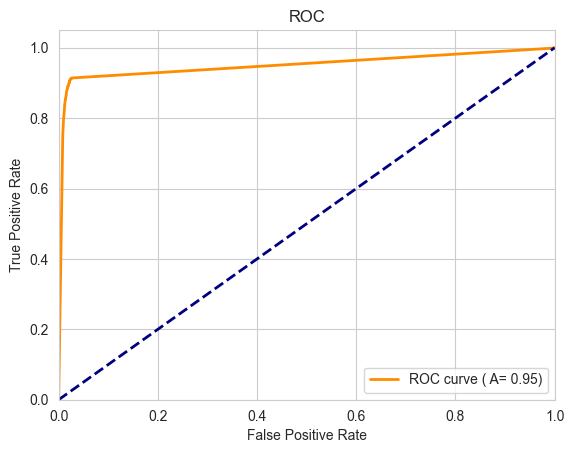

AUC score: 0.950181080616557


In [56]:
y_scores = forest_model.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)
#plotting roc
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve ( A= %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

print(f"AUC score: {roc_auc}")

The curve shows a high "true positive rate" with a low "false positive rate", indicating strong discriminatory power of the model. The area under the curve (**AUC**) of 0.95 confirms excellent model performance, signifying that the model has a 95% chance of correctly distinguishing between positive and negative classes. 

### LINK PREDICTION with Node2vec

In [43]:
ML_node2vec = Node2Vec(G, dimensions=20, walk_length=16, num_walks=100, workers=4)
ML_model = ML_node2vec.fit(window=10, min_count=1)


Computing transition probabilities:   0%|          | 0/5908 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:21<00:00,  1.19it/s]


In [45]:
np.random.seed(42)
list_edges = np.array([(u, v) for u, v in G.edges()])
test_size = int(len(list_edges) * 0.2) 

positive_indices = np.random.choice(len(list_edges), replace=False, size=test_size)
positive_instances = list_edges[positive_indices]

all_non_edges = np.array([(u, v) for u, v in nx.non_edges(G)])
negative_indices = np.random.choice(len(all_non_edges), replace=False, size=test_size)
negative_instances = all_non_edges[negative_indices]

datapoints = np.concatenate([positive_instances, negative_instances])

dataset = [ML_model.wv[str(u)] * ML_model.wv[str(v)] for u, v in datapoints]

dataset_link_prediction = pd.DataFrame(dataset, columns=[f'Dim_{i}' for i in range(20)])
dataset_link_prediction['label'] = [1] * len(positive_instances) + [0] * len(negative_instances)


In [50]:
dataset_link_prediction.head()

,Dim_0,Dim_1,Dim_2,Dim_3,Dim_4,Dim_5,Dim_6,Dim_7,Dim_8,Dim_9,...,Dim_11,Dim_12,Dim_13,Dim_14,Dim_15,Dim_16,Dim_17,Dim_18,Dim_19,label
0,1.501061,1.358936,0.145954,-0.066857,-0.077602,1.091266,1.278966,0.511731,0.211004,0.026484,...,0.641077,0.087139,0.103018,0.188468,1.860062,0.161121,0.242743,0.047381,0.241756,1
1,0.645250,-0.052364,0.008049,0.008242,1.911883,0.617893,0.760454,1.750908,0.112389,0.191851,...,-0.004349,0.476189,0.155508,0.131861,1.178278,0.636210,0.412316,2.074052,-0.003971,1
2,0.149176,0.028598,0.110799,0.188344,0.996783,-0.009300,-0.057053,1.729265,-0.039599,-0.011713,...,0.015312,0.173686,0.012894,0.148766,0.188232,0.062365,1.200206,0.539078,0.351814,1
3,2.153221,0.731762,0.217044,0.018352,0.818664,0.105236,0.054769,0.537910,1.332994,0.045510,...,0.758778,0.345141,0.912876,0.179165,0.508302,0.756941,0.048348,1.136363,0.142141,1
4,0.405876,-0.007238,0.010285,0.005650,0.027853,0.719863,0.660063,0.632560,0.487445,0.115401,...,0.049954,0.011162,0.607465,2.290461,0.373324,0.695652,0.175612,0.391199,2.016292,1


In [53]:
ML_X = dataset_link_prediction[[f'Dim_{i}' for i in range(20)]]  
ML_y = dataset_link_prediction['label']  

ML_X_train, ML_X_test, ML_y_train, ML_y_test = train_test_split(ML_X, ML_y, test_size=0.2, random_state=42)

ML_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
ML_forest_model.fit(ML_X_train, ML_y_train)

ML_y_pred = ML_forest_model.predict(ML_X_test)


ML_report = classification_report(ML_y_test, ML_y_pred)
ML_conf_matrix = confusion_matrix(ML_y_test, ML_y_pred)

print("Classification Report:\n", ML_report)
print("Confusion Matrix:\n", ML_conf_matrix)

Accuracy: 0.9682444577591373
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1661
           1       0.98      0.96      0.97      1677

    accuracy                           0.97      3338
   macro avg       0.97      0.97      0.97      3338
weighted avg       0.97      0.97      0.97      3338

Confusion Matrix:
 [[1629   32]
 [  74 1603]]


In the Random Forest model trained on the **Node2Vec embeddings**, the model achieved an overall accuracy of 96.82% (higher than before). This indicates that the model correctly predicted the link presence or absence between nodes with high reliability.

The precision score for the ‘no-link’ class (0) is 96%. For the ‘link’ class (1), precision is slightly higher at 98%, indicating the model is more reliable in predicting existing links between nodes.
The f1-score this time stands at 97% for both classes, showing that the model performs consistently across both precision and recall.

The confusion matrix reveals the model made relatively few errors: out of 3338 cases, only 32 were false positives (predicted links that don’t exist), and 74 were
false negatives.

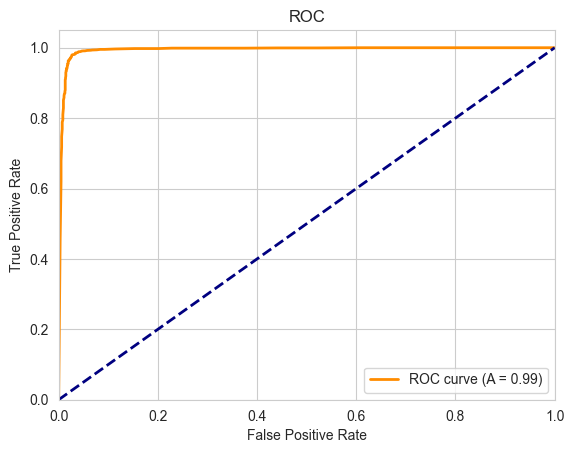

AUC: 0.9933462502382878


In [65]:
ML_y_probs = ML_forest_model.predict_proba(ML_X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(ML_y_test, ML_y_probs)

roc_auc = auc(fpr, tpr)

#plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (A = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)

The ROC curve presented here shows a near-perfect classifier performance with an AUC of 0.993. This value suggests that the model has an exceptional capability to discriminate between the positive and negative classes, correctly identifying the presence or absence of links with high accuracy.
However, the remarkable closeness of the ROC curve to the top left corner could raise concerns about potential overfitting.